#Waymo Open Dataset Tutorial

- Website: https://waymo.com/open
- GitHub: https://github.com/waymo-research/waymo-open-dataset

This tutorial demonstrates how to use the Waymo Open Dataset with two frames of data. Visit the [Waymo Open Dataset Website](https://waymo.com/open) to download the full dataset.

To use, open this notebook in [Colab](https://colab.research.google.com).

Uncheck the box "Reset all runtimes before running" if you run this colab directly from the remote kernel. Alternatively, you can make a copy before trying to run it by following "File > Save copy in Drive ...".



## Install waymo_open_dataset package

In [0]:
!rm -rf waymo-od > /dev/null
!git clone https://github.com/waymo-research/waymo-open-dataset.git waymo-od
!cd waymo-od && git branch -a
!cd waymo-od && git checkout remotes/origin/master
!pip3 install --upgrade pip

In [ ]:
!pip3 install waymo-open-dataset-tf-2-12-0==1.6.4
!pip3 install Pillow==9.2.0

In [2]:
import os
import tensorflow.compat.v1 as tf
import math
import numpy as np
import itertools
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tqdm
from collections import defaultdict
import json
import glob 

tf.enable_eager_execution()

from waymo_open_dataset.utils import range_image_utils
from waymo_open_dataset.utils import transform_utils
from waymo_open_dataset.utils import  frame_utils
from waymo_open_dataset import dataset_pb2 as open_dataset

2025-03-01 12:30:27.460540: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-01 12:30:27.543131: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-01 12:30:28.262131: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Read one frame

Each file in the dataset is a sequence of frames ordered by frame start timestamps. We have extracted two frames from the dataset to demonstrate the dataset format.

In [3]:
# FILENAME = '/content/waymo-od/tutorial/frames'
FILENAME = '/mnt/c/Users/Gaurav/Downloads/Datasets/waymo/waymo_open_dataset_v_1_4_1/training/individual_files_training_segment-10017090168044687777_6380_000_6400_000_with_camera_labels.tfrecord'
dataset = tf.data.TFRecordDataset(FILENAME, compression_type='')
frames = []
for data in dataset:
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    frames.append(frame)

# Total number of frames
print(f"Total number of frames: {len(frames)}")

2025-03-01 12:30:48.747762: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:64:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-01 12:30:48.917677: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-03-01 12:30:49.011482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


Total number of frames: 198


In [50]:
(range_images, camera_projections, _ , range_image_top_pose) = frame_utils.parse_range_image_and_camera_projection(frame)

###Examine frame context

Refer to [dataset.proto](https://github.com/waymo-research/waymo-open-dataset/blob/master/waymo_open_dataset/dataset.proto) for the data format. The context contains shared information among all frames in the scene.

In [51]:
print(frame.context)

name: "10017090168044687777_6380_000_6400_000"
camera_calibrations {
  name: FRONT
  intrinsic: 2059.612011552946
  intrinsic: 2059.612011552946
  intrinsic: 952.4121898799498
  intrinsic: 634.5872082485005
  intrinsic: 0.03545287376426267
  intrinsic: -0.33830085391165776
  intrinsic: 1.9229596190070855e-05
  intrinsic: 0.0007138551068011635
  intrinsic: 0.0
  extrinsic {
    transform: 0.9999785086634438
    transform: 0.003142074430868787
    transform: 0.005754092413724721
    transform: 1.5391467608686606
    transform: -0.0032444997400664865
    transform: 0.999834903267396
    transform: 0.017878462733512377
    transform: -0.02402951085443307
    transform: -0.005696966971249904
    transform: -0.017896747652793314
    transform: 0.9998236099386635
    transform: 2.115778469674332
    transform: 0.0
    transform: 0.0
    transform: 0.0
    transform: 1.0
  }
  width: 1920
  height: 1280
  rolling_shutter_direction: LEFT_TO_RIGHT
}
camera_calibrations {
  name: FRONT_LEFT
  int

In [55]:
frame.images[0].image
img = tf.image.decode_jpeg(frame.images[0].image).numpy()
img.shape

(1280, 1920, 3)

## Visualize Camera Images and Camera Labels

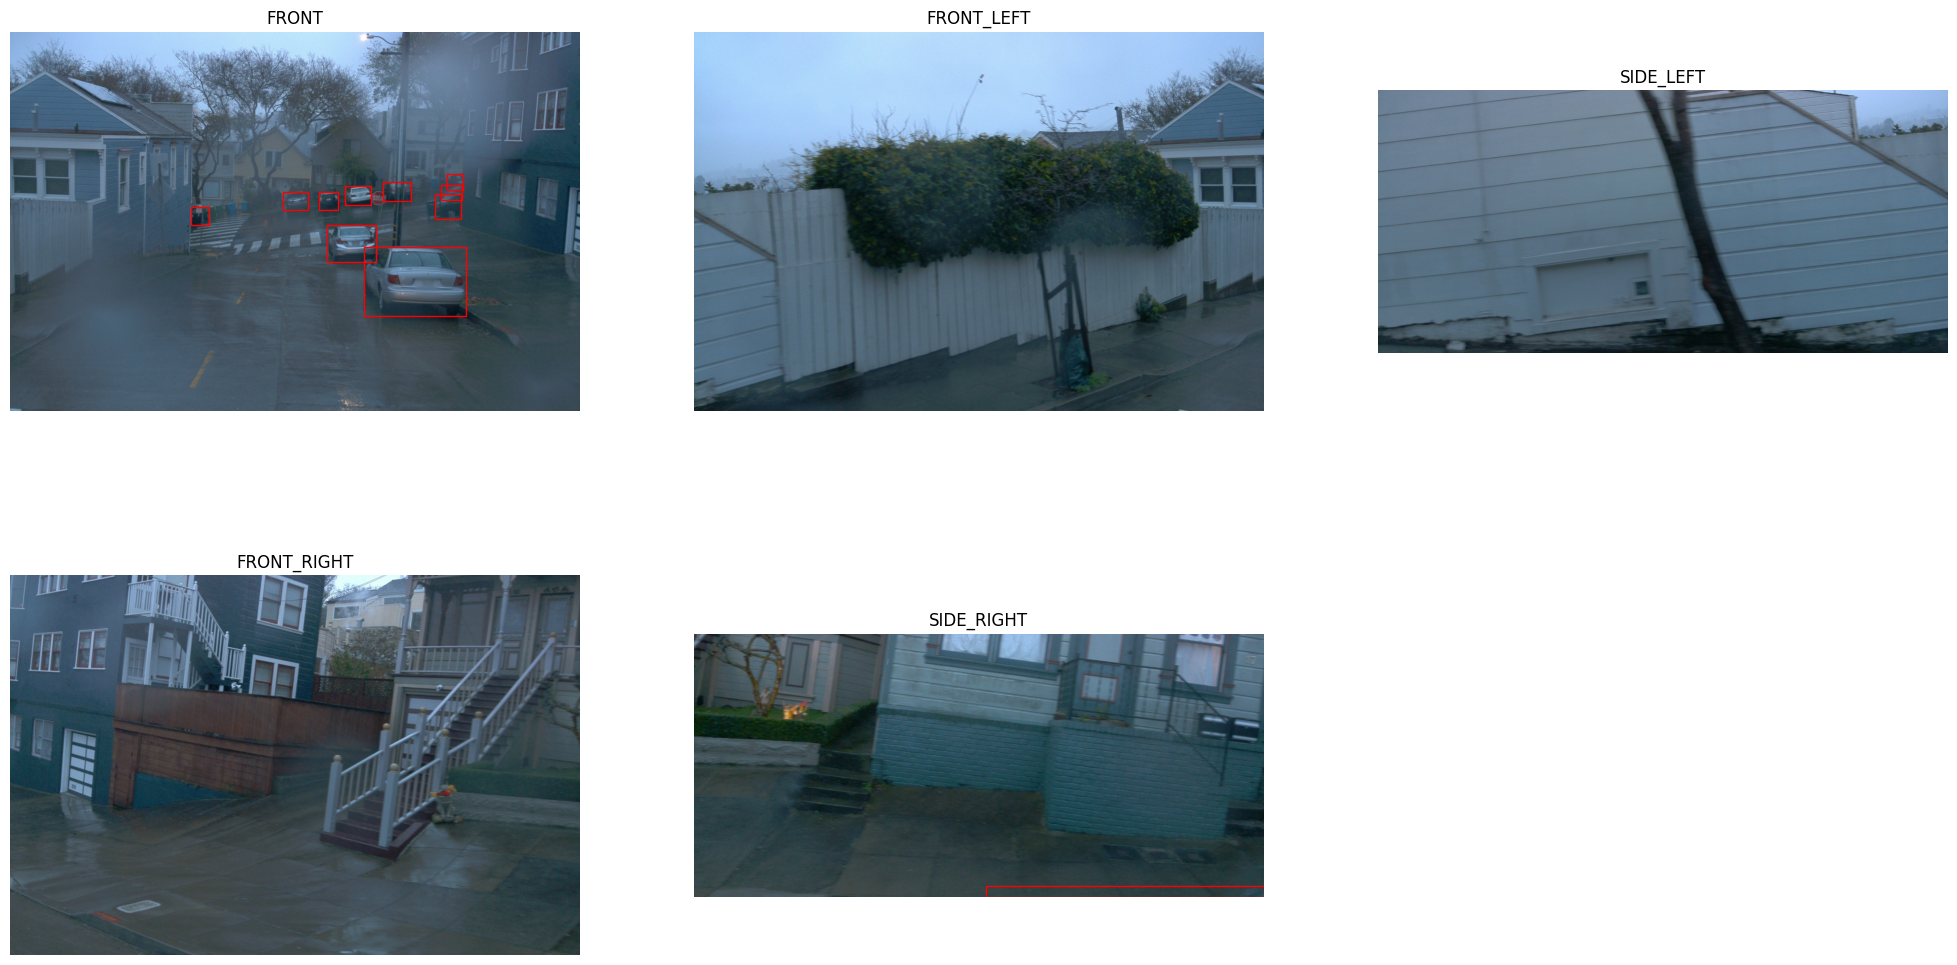

In [83]:
def show_camera_image(camera_image, camera_labels, layout, cmap=None):
  """Show a camera image and the given camera labels."""

  ax = plt.subplot(*layout)

  # Draw the camera labels.
  for camera_labels in frame.camera_labels:
    # Ignore camera labels that do not correspond to this camera.
    if camera_labels.name != camera_image.name:
      continue

    # Iterate over the individual labels.
    for label in camera_labels.labels:
      # Draw the object bounding box.
      ax.add_patch(patches.Rectangle(
        xy=(label.box.center_x - 0.5 * label.box.length,
            label.box.center_y - 0.5 * label.box.width),
        width=label.box.length,
        height=label.box.width,
        linewidth=1,
        edgecolor='red',
        facecolor='none'))

  # Show the camera image.
  plt.imshow(tf.image.decode_jpeg(camera_image.image), cmap=cmap)
  plt.title(open_dataset.CameraName.Name.Name(camera_image.name))
  plt.grid(False)
  plt.axis('off')

plt.figure(figsize=(25, 20))

for index, image in enumerate(frame.images):
  show_camera_image(image, frame.camera_labels, [3, 3, index+1])

##Visualize Range Images

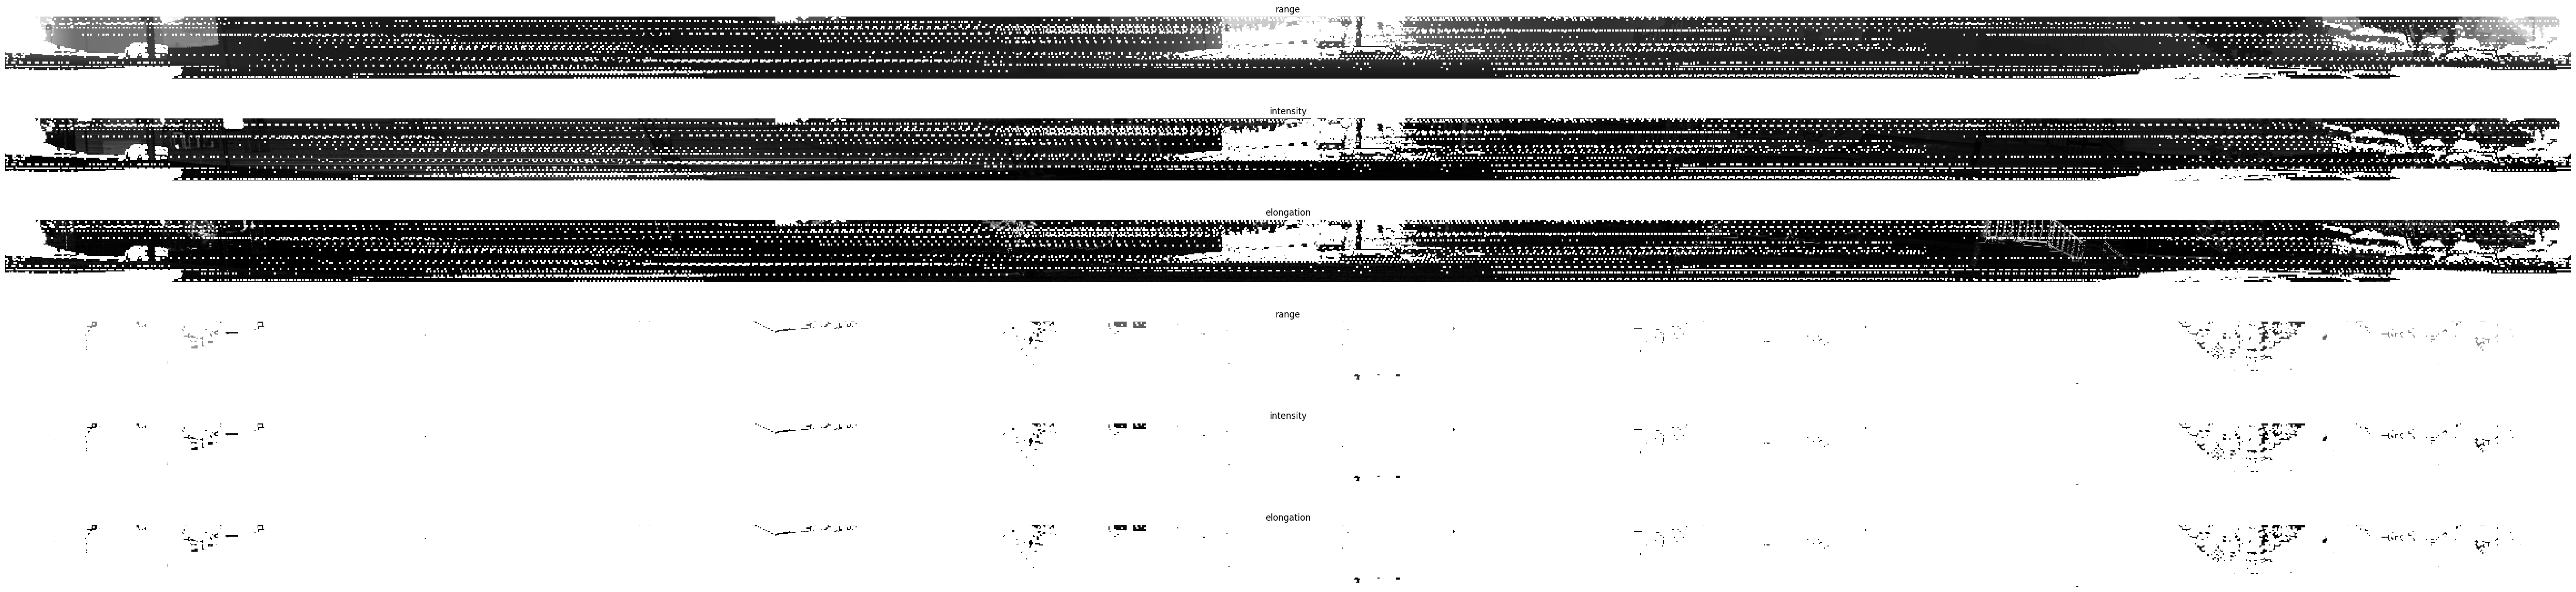

In [40]:
plt.figure(figsize=(64, 20))
def plot_range_image_helper(data, name, layout, vmin = 0, vmax=1, cmap='gray'):
  """Plots range image.

  Args:
    data: range image data
    name: the image title
    layout: plt layout
    vmin: minimum value of the passed data
    vmax: maximum value of the passed data
    cmap: color map
  """
  plt.subplot(*layout)
  plt.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
  plt.title(name)
  plt.grid(False)
  plt.axis('off')

def get_range_image(laser_name, return_index):
  """Returns range image given a laser name and its return index."""
  return range_images[laser_name][return_index]

def show_range_image(range_image, layout_index_start = 1):
  """Shows range image.

  Args:
    range_image: the range image data from a given lidar of type MatrixFloat.
    layout_index_start: layout offset
  """
  range_image_tensor = tf.convert_to_tensor(range_image.data)
  range_image_tensor = tf.reshape(range_image_tensor, range_image.shape.dims)
  lidar_image_mask = tf.greater_equal(range_image_tensor, 0)
  range_image_tensor = tf.where(lidar_image_mask, range_image_tensor,
                                tf.ones_like(range_image_tensor) * 1e10)
  range_image_range = range_image_tensor[...,0]
  range_image_intensity = range_image_tensor[...,1]
  range_image_elongation = range_image_tensor[...,2]
  plot_range_image_helper(range_image_range.numpy(), 'range',
                   [8, 1, layout_index_start], vmax=75, cmap='gray')
  plot_range_image_helper(range_image_intensity.numpy(), 'intensity',
                   [8, 1, layout_index_start + 1], vmax=1.5, cmap='gray')
  plot_range_image_helper(range_image_elongation.numpy(), 'elongation',
                   [8, 1, layout_index_start + 2], vmax=1.5, cmap='gray')
frame.lasers.sort(key=lambda laser: laser.name)
show_range_image(get_range_image(open_dataset.LaserName.TOP, 0), 1)
show_range_image(get_range_image(open_dataset.LaserName.TOP, 1), 4)

##Point Cloud Conversion and Visualization

In [41]:
points, cp_points = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose)
points_ri2, cp_points_ri2 = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose,
    ri_index=1)

# 3d points in vehicle frame.
points_all = np.concatenate(points, axis=0)
points_all_ri2 = np.concatenate(points_ri2, axis=0)
# camera projection corresponding to each point.
cp_points_all = np.concatenate(cp_points, axis=0)
cp_points_all_ri2 = np.concatenate(cp_points_ri2, axis=0)

###Examine number of points in each lidar sensor.

First return.

In [43]:
print(points_all.shape)
print(cp_points_all.shape)
print(points_all[0:2])
for i in range(5):
  print(points[i].shape)
  print(cp_points[i].shape)

(165857, 3)
(165857, 6)
[[-72.638       5.2929688   4.731079 ]
 [-71.06091     5.352539    4.6772156]]
(149739, 3)
(149739, 6)
(3333, 3)
(3333, 6)
(4462, 3)
(4462, 6)
(3262, 3)
(3262, 6)
(5061, 3)
(5061, 6)


Second return.

In [44]:
print(points_all_ri2.shape)
print(cp_points_all_ri2.shape)
print(points_all_ri2[0:2])
for i in range(5):
  print(points_ri2[i].shape)
  print(cp_points_ri2[i].shape)

(5837, 3)
(5837, 6)
[[-31.539581    5.899414    3.331314 ]
 [-31.741028    7.0703125   3.3473969]]
(5724, 3)
(5724, 6)
(8, 3)
(8, 6)
(34, 3)
(34, 6)
(6, 3)
(6, 6)
(65, 3)
(65, 6)


###Show point cloud
3D point clouds are rendered using an internal tool, which is unfortunately not publicly available yet. Here is an example of what they look like.

In [ ]:
from IPython.display import Image, display
display(Image('/content/waymo-od/tutorial/3d_point_cloud.png'))

##Visualize Camera Projection

In [46]:
images = sorted(frame.images, key=lambda i:i.name)
cp_points_all_concat = np.concatenate([cp_points_all, points_all], axis=-1)
cp_points_all_concat_tensor = tf.constant(cp_points_all_concat)

# The distance between lidar points and vehicle frame origin.
points_all_tensor = tf.norm(points_all, axis=-1, keepdims=True)
cp_points_all_tensor = tf.constant(cp_points_all, dtype=tf.int32)

mask = tf.equal(cp_points_all_tensor[..., 0], images[0].name)

cp_points_all_tensor = tf.cast(tf.gather_nd(
    cp_points_all_tensor, tf.where(mask)), dtype=tf.float32)
points_all_tensor = tf.gather_nd(points_all_tensor, tf.where(mask))

projected_points_all_from_raw_data = tf.concat(
    [cp_points_all_tensor[..., 1:3], points_all_tensor], axis=-1).numpy()

In [47]:
def rgba(r):
  """Generates a color based on range.

  Args:
    r: the range value of a given point.
  Returns:
    The color for a given range
  """
  c = plt.get_cmap('jet')((r % 20.0) / 20.0)
  c = list(c)
  c[-1] = 0.5  # alpha
  return c

def plot_image(camera_image):
  """Plot a cmaera image."""
  plt.figure(figsize=(20, 12))
  plt.imshow(tf.image.decode_jpeg(camera_image.image))
  plt.grid("off")

def plot_points_on_image(projected_points, camera_image, rgba_func,
                         point_size=5.0):
  """Plots points on a camera image.

  Args:
    projected_points: [N, 3] numpy array. The inner dims are
      [camera_x, camera_y, range].
    camera_image: jpeg encoded camera image.
    rgba_func: a function that generates a color from a range value.
    point_size: the point size.

  """
  plot_image(camera_image)

  xs = []
  ys = []
  colors = []

  for point in projected_points:
    xs.append(point[0])  # width, col
    ys.append(point[1])  # height, row
    colors.append(rgba_func(point[2]))

  plt.scatter(xs, ys, c=colors, s=point_size, edgecolors="none")

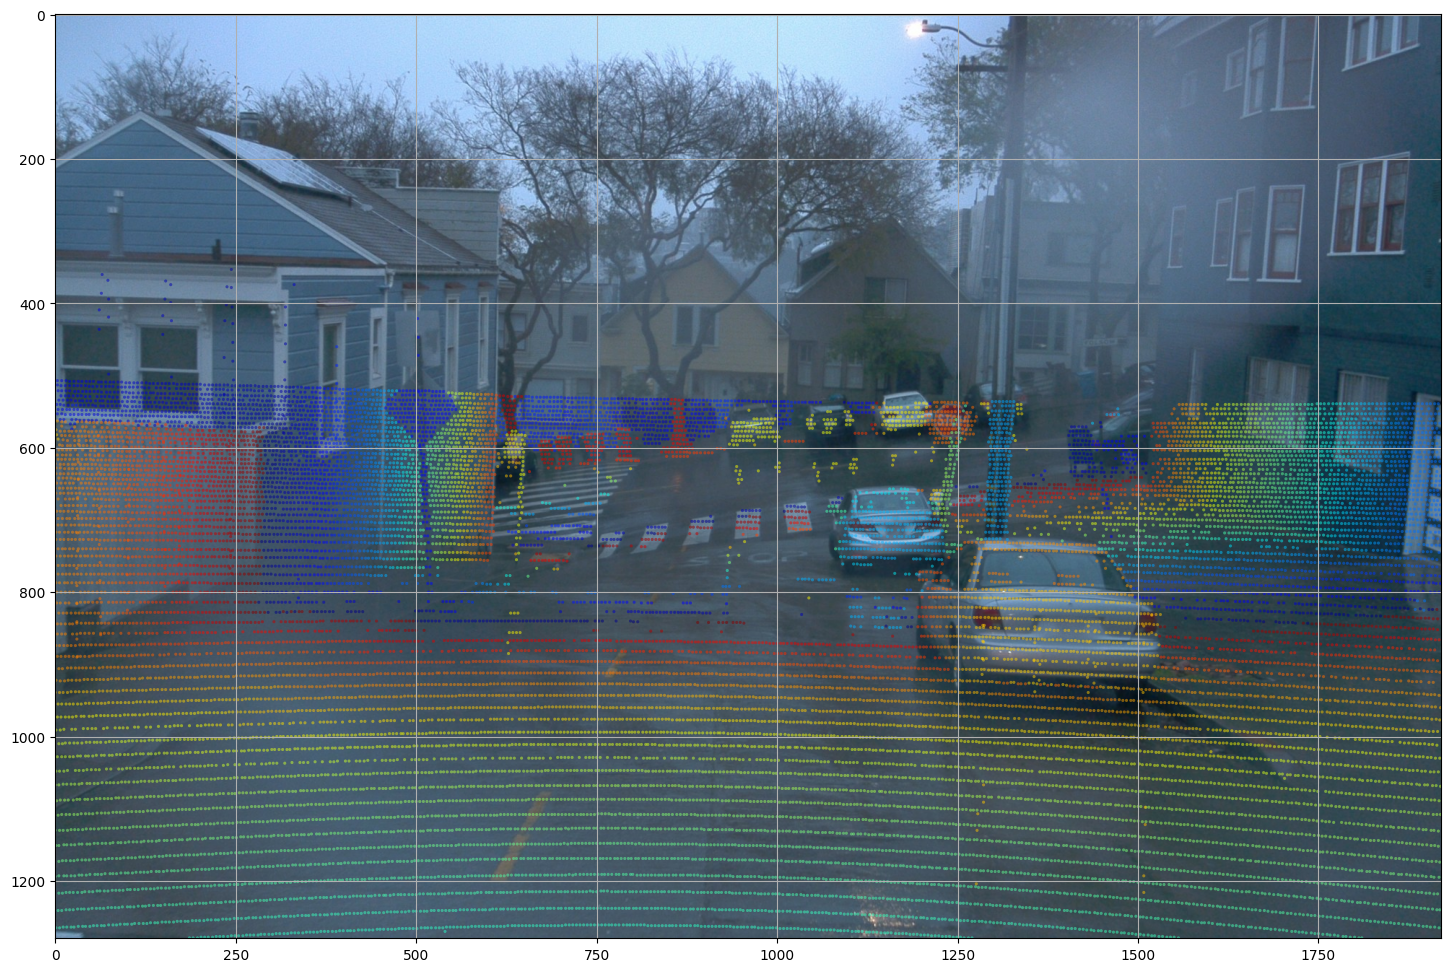

In [48]:
plot_points_on_image(projected_points_all_from_raw_data,
                     images[0], rgba, point_size=5.0)

## Install from source code

The remaining part of this colab covers details of installing the repo form source code which provides a richer API.

### Install dependencies

In [0]:
!npm install -g @bazel/bazelisk

###Build and test

NOTE: It can take 10-30 mins (sometimes more) depending on available compute resources.

Configure .bazelrc. This works with/without Tensorflow. This colab machine has Tensorflow installed.

In [0]:
!pip3 install patchelf
!cd /content/waymo-od/src/ && bazelisk test //waymo_open_dataset/... --show_progress_rate_limit=10.0

### Metrics computation
The core metrics computation library is written in C++, so it can be extended to other programming languages. It can compute detection metrics (mAP) and tracking metrics (MOTA). See more information about the metrics on the [website](https://waymo.com/open/next/).

We provide command line tools and TensorFlow ops to call the detection metrics library to compute detection metrics. We will provide a similar wrapper for tracking metrics library in the future. You are welcome to contribute your wrappers.

#### Command line detection metrics computation

The command takes a pair of files for prediction and ground truth. Read the comment in waymo_open_dataset/metrics/tools/compute_detection_metrics_main.cc for details of the data format.

In [0]:
!cd /content/waymo-od/src/ && bazel-bin/waymo_open_dataset/metrics/tools/compute_detection_metrics_main waymo_open_dataset/metrics/tools/fake_predictions.bin  waymo_open_dataset/metrics/tools/fake_ground_truths.bin

### Build local PIP package

In [0]:
!cd /content/waymo-od/src/ && bazelisk build -c opt  //waymo_open_dataset/pip_pkg_scripts:wheel
!ls -R -l -h /content/waymo-od/src/bazel-bin/waymo_open_dataset/pip_pkg_scripts/waymo_open_dataset_tf_2.12.0*

You can install the locally compiled package or access any c++ binary compiled from this.

## Saving image and 2d labels

In [17]:
# frame.context
# frame.images
# frame.camera_labels
# camera_id = open_dataset.CameraName.Name.Name(frame.images[0].name)

[name: FRONT
labels {
  box {
    center_x: 1073.07141
    center_y: 570.3257699999999
    width: 60.001049999999964
    length: 65.68535999999995
  }
  type: TYPE_VEHICLE
  id: "1fa40b66-1897-4d0b-93e9-a9445372962b"
}
labels {
  box {
    center_x: 1303.60176
    center_y: 538.11468
    width: 63.79059000000001
    length: 95.37009000000012
  }
  type: TYPE_VEHICLE
  id: "390532ce-170a-4195-bb33-3da06867538d"
}
labels {
  box {
    center_x: 1172.86263
    center_y: 552.6412499999999
    width: 63.79058999999995
    length: 86.52783
  }
  type: TYPE_VEHICLE
  id: "56582dbe-aa18-4743-9bea-2dff4ab1288f"
}
labels {
  box {
    center_x: 961.91157
    center_y: 570.3257699999999
    width: 63.79058999999995
    length: 85.26464999999996
  }
  type: TYPE_VEHICLE
  id: "66355bd8-db76-4a7c-99e6-3294a45825c1"
}
labels {
  box {
    center_x: 1363.6028099999999
    center_y: 841.27788
    width: 233.68830000000003
    length: 345.47973
  }
  type: TYPE_VEHICLE
  id: "66521395-87a2-4a07-99a4-be

In [102]:
dir_path = '/mnt/c/Users/Gaurav/Downloads/Datasets/waymo/waymo_open_dataset_v_1_4_1/training'

In [140]:
# FILENAME = '/content/waymo-od/tutorial/frames'
seq_dirs = glob.glob(os.path.join(dir_path, '*.tfrecord'))
seq_frames = []
for seq_dir in seq_dirs:
    dataset = tf.data.TFRecordDataset(seq_dir, compression_type='')
    frames = []
    for data in dataset:
        frame = open_dataset.Frame()
        frame.ParseFromString(bytearray(data.numpy()))
        frames.append(frame)

    # Total number of frames
    print(f"Total number of frames: {len(frames)}")
    seq_frames.append(frames)

2025-03-01 14:45:42.968707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


Total number of frames: 198


2025-03-01 14:45:51.755715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


Total number of frames: 199


2025-03-01 14:45:59.676512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


Total number of frames: 198


In [143]:
for frames in seq_frames[2:]:
    for i, frame in tqdm.tqdm(enumerate(frames),  total=len(frames), desc="Saving images"):
        seq_name = frame.context.name # sequence name
        frame_id = f"{i:05d}"
        output_dir_img = os.path.join(dir_path, seq_name, "images") # Image directory for the sequence
        os.makedirs(output_dir_img, exist_ok=True)
        
        # Create a subdirectory for each camera ID and save frame image in that subdirectory    
        for frame_image in frame.images:
            camera_id = open_dataset.CameraName.Name.Name(frame_image.name) # Get camera ID
            image_dir = os.path.join(output_dir_img, camera_id)
            os.makedirs(image_dir, exist_ok=True)
            image_path = os.path.join(image_dir, f"{frame_id}.jpg") # Save the image to the directory

            img = tf.image.decode_jpeg(frame_image.image).numpy() # Decode the JPEG image
            cv2.imwrite(image_path, cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # Save using OpenCV RGB color space

Saving images: 100%|██████████| 198/198 [00:58<00:00,  3.39it/s]


In [144]:
for frames in seq_frames:
    for i, frame in tqdm.tqdm(enumerate(frames),  total=len(frames), desc="Saving 2d labels"):
        seq_name = frame.context.name # sequence name
        frame_id = f"{i:05d}"
        output_dir_label = os.path.join(dir_path, seq_name, "2d_labels") # 2d Labels directory for the sequence
        os.makedirs(output_dir_label, exist_ok=True)
        
        # Create a subdirectory for each camera ID and save frame image in that subdirectory    
        for frame_image in frame.images:
            camera_id = open_dataset.CameraName.Name.Name(frame_image.name) # Get camera ID
            label_dir = os.path.join(output_dir_label, camera_id)
            os.makedirs(label_dir, exist_ok=True)
            json_path = os.path.join(label_dir, f"{frame_id}.json") # Save the image to the directory

            # Iterate over the labels for each camera ID
            for camera_labels in frame.camera_labels:
                if camera_labels.name != frame_image.name:
                    continue

                # Iterate over the individual labels.
                labels = list()
                for label in camera_labels.labels:
                    label_= {
                        "pos_xywh": [label.box.center_x, label.box.center_y, label.box.length, label.box.width],
                        "type": label.type,
                        "id": label.id,                    
                    }
                    labels.append(label_)

                # Save the labels to a JSON file.
                labels_dict = {
                    frame_id: {"camera_id": camera_id, "labels": labels}
                    }
                with open(json_path, "w") as f:
                    json.dump(labels_dict, f, indent=4)

Saving 2d labels: 100%|██████████| 198/198 [00:15<00:00, 12.91it/s]


#### Sanity check

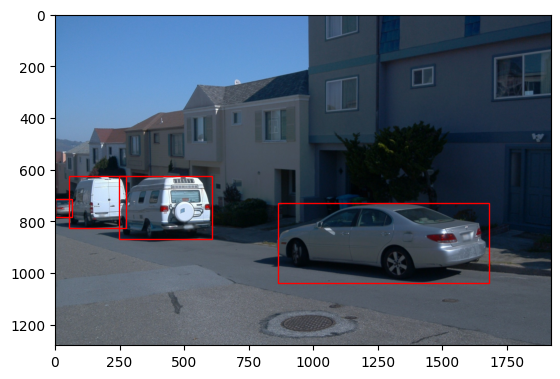

In [147]:
frame_id = '00010'
img = plt.imread(os.path.join(output_dir_img, f"FRONT/{frame_id}.jpg"))
with open(os.path.join(output_dir_label, f"FRONT/{frame_id}.json")) as f:
    anns_data = json.load(f)

fig = plt.subplot(1,1,1)

# Iterate over the individual labels.
for ann in anns_data[frame_id]['labels']:
    
    # Draw the object bounding box.
    fig.add_patch(patches.Rectangle(
    xy=(ann['pos_xywh'][0] - 0.5 * ann['pos_xywh'][2],
        ann['pos_xywh'][1] - 0.5 * ann['pos_xywh'][3]),
    width=ann['pos_xywh'][2],
    height=ann['pos_xywh'][3],
    linewidth=1,
    edgecolor='red',
    facecolor='none'))
    
plt.imshow(img)